In [1]:
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import torch
from nltk.translate.bleu_score import sentence_bleu
import torch

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# ====== 1. Load Dataset ======
dataset = load_dataset("SEACrowd/liputan6", trust_remote_code=True)
train_data = dataset["train"].shuffle(seed=42).select(range(1000))
val_data = dataset["validation"].shuffle(seed=42).select(range(200))
test_data = dataset["test"].shuffle(seed=42).select(range(200))

# Assuming a tokenizer function (from preprocessing)
def custom_tokenizer(text, vocab, max_len=512):
    tokens = text.split()[:max_len]  # Truncate to max_len
    token_ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]  # Map to vocab IDs
    padding = [vocab["<pad>"]] * (max_len - len(token_ids))  # Pad to max_len
    return token_ids + padding

# Create a custom vocabulary for the tokenizer
vocab = {"<pad>": 0, "<unk>": 1, "<s>": 2, "</s>": 3}
index = len(vocab)
for data in train_data["document"]:
    for word in data.split():
        if word not in vocab:
            vocab[word] = index
            index += 1


Using the latest cached version of the module from C:\Users\ASUS\.cache\huggingface\modules\datasets_modules\datasets\SEACrowd--liputan6\92889ba1fdfc1c0166465f7a21ead34100f6188cff9796ac235d589978d0c01c (last modified on Thu Nov  7 10:27:07 2024) since it couldn't be found locally at SEACrowd/liputan6, or remotely on the Hugging Face Hub.


In [3]:

# ====== 2. Dataset Preparation ======
class CustomTokenizerDataset(Dataset):
    def __init__(self, articles, summaries, tokenizer, vocab, max_len=512):
        self.articles = articles
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        article = self.articles[idx]
        summary = self.summaries[idx]

        article_ids = self.tokenizer(article, self.vocab, max_len=self.max_len)
        summary_ids = self.tokenizer(summary, self.vocab, max_len=self.max_len)

        return {
            "input_ids": torch.tensor(article_ids, dtype=torch.long),
            "target_ids": torch.tensor(summary_ids, dtype=torch.long),
        }

train_dataset = CustomTokenizerDataset(
    train_data["document"], train_data["summary"], custom_tokenizer, vocab
)
val_dataset = CustomTokenizerDataset(
    val_data["document"], val_data["summary"], custom_tokenizer, vocab
)
test_dataset = CustomTokenizerDataset(
    test_data["document"], test_data["summary"], custom_tokenizer, vocab
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [4]:

# ====== 3. Define Transformer Model ======
class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, ff_dim, num_layers, max_len=512):
        super(Seq2SeqTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=ff_dim,
        )
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, src, tgt):
        src_embed = self.embedding(src).permute(1, 0, 2)  # (seq_len, batch_size, embed_size)
        tgt_embed = self.embedding(tgt).permute(1, 0, 2)
        transformer_out = self.transformer(src_embed, tgt_embed)
        output = self.fc(transformer_out).permute(1, 0, 2)  # (batch_size, seq_len, vocab_size)
        return output


In [5]:

# ====== 4. Training and Evaluation ======
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        target_ids = batch["target_ids"].to(device)

        optimizer.zero_grad()
        output = model(input_ids, target_ids[:, :-1])  # Teacher forcing
        loss = criterion(output.reshape(-1, output.size(-1)), target_ids[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)




def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            target_ids = batch["target_ids"].to(device)

            output = model(input_ids, target_ids[:, :-1])
            loss = criterion(output.reshape(-1, output.size(-1)), target_ids[:, 1:].reshape(-1))
            total_loss += loss.item()
    return total_loss / len(dataloader)



In [6]:

# Plotting training and validation loss
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()



In [7]:
def decode_token_ids(token_ids, vocab):
    """Decode token IDs back into text using vocab mapping."""
    id_to_token = {v: k for k, v in vocab.items()}
    tokens = [id_to_token[token_id] for token_id in token_ids if token_id != vocab["<pad>"]]
    return " ".join(tokens)

def calculate_bleu(model, dataloader, tokenizer, vocab, device):
    model.eval()
    scores = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            target_ids = batch["target_ids"].to(device)

            # Generate predictions
            output = model(input_ids, target_ids[:, :-1])
            predictions = torch.argmax(output, dim=-1).cpu().numpy()

            # Decode predictions and targets to text
            for pred, target in zip(predictions, target_ids.cpu().numpy()):
                pred_text = decode_token_ids(pred, vocab)
                target_text = decode_token_ids(target, vocab)
                scores.append(sentence_bleu([target_text.split()], pred_text.split()))

    return sum(scores) / len(scores)


Epoch 1: Train Loss = 9.0139, Val Loss = 8.1777
Epoch 2: Train Loss = 7.9774, Val Loss = 7.6073
Epoch 3: Train Loss = 7.5846, Val Loss = 7.4566
Epoch 4: Train Loss = 7.4530, Val Loss = 7.4255
Epoch 5: Train Loss = 7.3933, Val Loss = 7.3956
Epoch 6: Train Loss = 7.3364, Val Loss = 7.3315
Epoch 7: Train Loss = 7.2673, Val Loss = 7.3006
Epoch 8: Train Loss = 7.1900, Val Loss = 7.2593
Epoch 9: Train Loss = 7.1024, Val Loss = 7.2177
Epoch 10: Train Loss = 7.0049, Val Loss = 7.1966


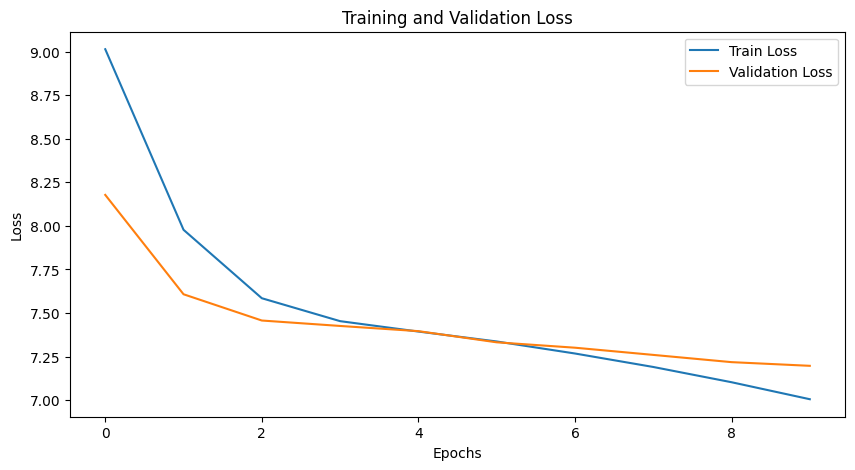

In [8]:

# ====== 5. Main Training Loop ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(vocab)
embed_size = 256
num_heads = 8
ff_dim = 512
num_layers = 4

model = Seq2SeqTransformer(vocab_size, embed_size, num_heads, ff_dim, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])

train_losses, val_losses = [], []
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate_model(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

plot_loss(train_losses, val_losses)


In [9]:
bleu_score = calculate_bleu(model, test_loader, custom_tokenizer, vocab, device)
print(f"BLEU Score: {bleu_score}")


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

BLEU Score: 2.5825751723324873e-80


In [10]:
def generate_summary(model, input_text, tokenizer, vocab, device, max_len=50):
    """
    Generate a summary for a given input text using the model.
    """
    model.eval()
    with torch.no_grad():
        # Tokenize the input text
        input_ids = torch.tensor(
            [tokenizer(input_text, vocab, max_len=max_len)], dtype=torch.long
        ).to(device)

        # Start token for generation
        start_token = vocab["<s>"]
        end_token = vocab["</s>"]

        # Initialize the target sequence with the start token
        target_ids = torch.tensor([[start_token]], dtype=torch.long).to(device)

        for _ in range(max_len):
            # Generate output probabilities
            output = model(input_ids, target_ids)
            next_token = torch.argmax(output[:, -1, :], dim=-1)

            # Append the next token to the target sequence
            target_ids = torch.cat([target_ids, next_token.unsqueeze(0)], dim=1)

            # Stop if end token is generated
            if next_token.item() == end_token:
                break

        # Decode the generated token IDs into text
        generated_summary = decode_token_ids(target_ids.squeeze().tolist(), vocab)
        return generated_summary

# Generate summaries for test data
def predict_summaries_original(model, dataset, tokenizer, vocab, device, num_samples=10, max_len=50):
    """
    Generate and display predicted summaries using original text input.
    """
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(num_samples):
            # Load original text input and target
            input_text = dataset[i]["document"]
            target_text = dataset[i]["summary"]

            # Tokenize the original input text
            input_ids = torch.tensor(
                [tokenizer(input_text, vocab, max_len=max_len)], dtype=torch.long
            ).to(device)

            # Generate summary
            predicted_summary = generate_summary(
                model, input_text, tokenizer, vocab, device, max_len=max_len
            )

            predictions.append({
                "input": input_text,
                "target": target_text,
                "predicted": predicted_summary
            })

    return predictions


In [11]:
from datasets import load_dataset

# Load the Liputan6 dataset
dataset = load_dataset("SEACrowd/liputan6", trust_remote_code=True)

# Select the test set
test_data = dataset["test"]

# Generate predictions
predictions = predict_summaries_original(model, test_data, custom_tokenizer, vocab, device, num_samples=5)

# Display predictions
for i, pred in enumerate(predictions):
    print(f"Sample {i + 1}")
    print(f"Input: {pred['input']}")
    print(f"Target: {pred['target']}")
    print(f"Predicted: {pred['predicted']}")
    print("-" * 50)


Using the latest cached version of the module from C:\Users\ASUS\.cache\huggingface\modules\datasets_modules\datasets\SEACrowd--liputan6\92889ba1fdfc1c0166465f7a21ead34100f6188cff9796ac235d589978d0c01c (last modified on Thu Nov  7 10:27:07 2024) since it couldn't be found locally at SEACrowd/liputan6, or remotely on the Hugging Face Hub.


Sample 1
Input: Liputan6 . com , Bangka : Kapal patroli Angkatan Laut Republik Indonesia , Belinyu , baru-baru ini , menangkap tiga kapal nelayan berbendera Thailand , yakni KM Binatama , KM Sumber Jaya II , dan KM Mataram di Perairan Belitung Utara . Ketiga kapal itu ditangkap karena melanggar zona ekonomi ekslusif Indonesia . Saat ini , kapal-kapal itu diamankan di Pos Lanal Pelabuhan Pangkalan Balam , Bangka-Belitung . Menurut Komandan Pangkalan TNI AL Bangka Letnan Kolonel Laut Fredy Egam , selain menangkap tiga kapal , ALRI juga memeriksa 43 anak buah kapal . Mereka disergap saat sedang mengangkat jaring pukat harimau di Perairan Belitung Utara . Dari jumlah itu , hanya enam orang yang dijadikan tersangka , yakni tiga nahkoda dan tiga kepala kamar mesin kapal . Sedangkan ABK yang lain akan dideportasi ke negara asalnya . Meski berhasil menahan enam tersangka , TNI AL gagal mengamankan ikan tangkapan nelayan Thailand tersebut . Sebab , sebelum patroli datang , mereka telah memindah

In [12]:
def inspect_tokenization(tokenizer, vocab, text, max_len=50):
    """
    Inspect the tokenization, sequence, and padding for a given text.
    """
    print("Original Text:")
    print(text)
    print("\nTokenized IDs:")
    token_ids = tokenizer(text, vocab, max_len=max_len)
    print(token_ids)

    print("\nTokenized Tokens:")
    id_to_token = {v: k for k, v in vocab.items()}
    tokens = [id_to_token.get(token_id, "<UNK>") for token_id in token_ids]
    print(tokens)

    print("\nPadded Sequence:")
    print(token_ids)

# Example usage with one sample from the dataset
sample = test_data[0]  # Replace with your dataset object
input_text = sample["document"]

inspect_tokenization(custom_tokenizer, vocab, input_text, max_len=50)


Original Text:
Liputan6 . com , Bangka : Kapal patroli Angkatan Laut Republik Indonesia , Belinyu , baru-baru ini , menangkap tiga kapal nelayan berbendera Thailand , yakni KM Binatama , KM Sumber Jaya II , dan KM Mataram di Perairan Belitung Utara . Ketiga kapal itu ditangkap karena melanggar zona ekonomi ekslusif Indonesia . Saat ini , kapal-kapal itu diamankan di Pos Lanal Pelabuhan Pangkalan Balam , Bangka-Belitung . Menurut Komandan Pangkalan TNI AL Bangka Letnan Kolonel Laut Fredy Egam , selain menangkap tiga kapal , ALRI juga memeriksa 43 anak buah kapal . Mereka disergap saat sedang mengangkat jaring pukat harimau di Perairan Belitung Utara . Dari jumlah itu , hanya enam orang yang dijadikan tersangka , yakni tiga nahkoda dan tiga kepala kamar mesin kapal . Sedangkan ABK yang lain akan dideportasi ke negara asalnya . Meski berhasil menahan enam tersangka , TNI AL gagal mengamankan ikan tangkapan nelayan Thailand tersebut . Sebab , sebelum patroli datang , mereka telah memindahk